In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "Production Level Agents"
os.environ["LANGSMITH_Tracing"] = "true"

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

In [3]:
from pydantic import BaseModel

class AgentState(BaseModel):
    user_question : str
    needs_search : bool
    search_result : str
    final_answer : str
    reasoning : str

In [4]:
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool
def wikipedia_search(query: str)->str:
    """Search wikipedia for current information about topic"""
    wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=400)
    wiki_search = WikipediaQueryRun(api_wrapper=wrapper)
    wiki_tool = wiki_search.invoke(query)
    return wiki_tool


In [5]:
#Deciding whether to search
from langchain_core.messages import SystemMessage

def decide_search_need(state:AgentState)-> AgentState:
    """
    Analyse the question and decide whether to search for currrent information
    """
    user_question = state.user_question
    decision_prompt = f"""
        Analyze the user query and decide whether need current/recent data that might not be avilable in tracing data.

        Question:"{user_question}"

        Consider:
        - Does this ask about recent events, current prices, or breaking news?.
        - Does this ask about people, companies, or topics that change frequently?
        - Can you answer this well using your existing knowledge?

        Respond with exactly "SEARCH" if you need current information, or "DIRECT" if you can answer directly.
        Then on a new line, briefly explain your reasoning.
    """ 
    response = llm.invoke([SystemMessage(content= decision_prompt)])
    decision_text = response.content.strip()

    lines = decision_text.split("\n")
    decision = lines[0].strip()
    reasoning = lines[1] if len(lines) > 1 else "No response provided"

    state.needs_search = decision == "SEARCH"
    state.reasoning = f"Decision: {decision}. Reasoning: {reasoning}"

    print(f"Decision: {'SEARCH' if state.needs_search else 'DIRECT'} - {reasoning} ")
    return state

#Executing Search when needed

In [6]:
def execute_search(state:AgentState)->AgentState:
    """Execute search if needed otherwise skip this step"""
    if not state.needs_search:
        print("Skipping search - not needed for this question")
        state.search_result = "No search performed"
        return state
    print(f"Executing search for: {state.user_question}")

    search_result = wikipedia_search({"query": state.user_question})
    state.search_result = search_result

    print(f"Search complete: {len(state.search_result)} characters returned.")

    return state

#Getting Final Response

In [7]:
def generate_response(state: AgentState)->AgentState:
    """Generate the final response using all the available information"""
    user_question = state.user_question
    search_result = state.search_result if state.search_result else " "
    used_search = state.needs_search

    if used_search and "Search error" not in search_result:
        context = f"Question: {user_question}\n\nSearch Result: {search_result}"
        response_prompt = f"""
            Answer the question using both your knowledge and the search results provided.
            Context: {context}
            Provide a helpful and accurate response the synthesises the information.
        """
    else:
        response_prompt = f"""
            Answer the following question using your existing knowledge.
            Question: {user_question}
            Provide an helpful, accurate response.
        """
    
    response = llm.invoke([SystemMessage(content= response_prompt)])
    state.final_answer = response.content

    print(f"Response generated: {len(response.content)} characters")
    return state

#Assembling Flow

In [8]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

#nodes
workflow.add_node("decide", decide_search_need)
workflow.add_node("search", execute_search)
workflow.add_node("generate", generate_response)

#edges
workflow.add_edge(START, "decide")
workflow.add_edge("decide", "search")
workflow.add_edge("search", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile()

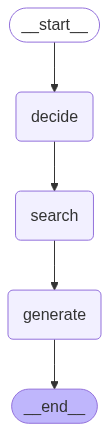

In [9]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

#Testing with full Observability

In [14]:
import time

def run_test_with_observability(question: str, test_type: str) -> dict:
    """Run a test and capture comprehensive observability data."""
    print(f"\n{'='*60}")
    print(f"Testing: {question}")
    print(f"Type: {test_type}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Initialize state for this test
    initial_state = {
        "user_question": question,
        "needs_search": False,
        "search_result": "",
        "final_answer": "",
        "reasoning": ""
    }
    
    try:
        # Execute with metadata for LangSmith
        # This metadata will help you filter and analyze traces later
        config = {
            "metadata": {
                "test_type": test_type,
                "tutorial": "langsmith-observability"
            },
            "tags": ["tutorial", "demo", test_type]
        }
        
        # This invoke call will create a complete trace in LangSmith
        final_state = graph.invoke(initial_state, config=config)
        
        end_time = time.time()
        total_time = end_time - start_time
        
        # Display results for immediate feedback
        print(f"\nResults:")
        print(f"   Decision Process: {final_state['reasoning']}")
        print(f"   Used Search: {'Yes' if final_state['needs_search'] else 'No'}")
        print(f"   Response Length: {len(final_state['final_answer'])} characters")
        print(f"   Total Time: {total_time:.2f} seconds")
        print(f"\nAnswer: {final_state['final_answer'][:200]}...")
        
        return {
            "question": question,
            "type": test_type,
            "success": True,
            "used_search": final_state['needs_search'],
            "total_time": round(total_time, 2),
            "reasoning": final_state['reasoning']
        }
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return {
            "question": question,
            "type": test_type,
            "success": False,
            "error": str(e)
        }


#Running test-cases

In [16]:
test_cases = [
    {
        "question": "What is the capital of France?",
        "type": "direct_answer",
        "expected_search": False
    },
    {
        "question": "What happened in the 2024 US presidential election?",
        "type": "current_info",
        "expected_search": True
    },
    {
        "question": "Tell me about artificial intelligence",
        "type": "factual_lookup",
        "expected_search": False  # Should be answerable directly
    }
]

print("Starting LangSmith Observability Demo")
print("Each test will generate detailed traces in your LangSmith dashboard")
print("Visit https://smith.langchain.com to see real-time traces\n")

test_results = []

for i, test_case in enumerate(test_cases, 1):
    print(f"\nRunning Test {i}/{len(test_cases)}")
    
    result = run_test_with_observability(
        test_case["question"], 
        test_case["type"]
    )
    
    test_results.append(result)
    
    # Small delay to make the traces easier to distinguish in LangSmith
    time.sleep(1)

print(f"\n\nAll tests completed")
print(f"Generated {len(test_results)} traces in LangSmith")
print(f"Check your dashboard to explore the detailed execution data")

Starting LangSmith Observability Demo
Each test will generate detailed traces in your LangSmith dashboard
Visit https://smith.langchain.com to see real-time traces


Running Test 1/3

Testing: What is the capital of France?
Type: direct_answer
Decision: DIRECT -  
Skipping search - not needed for this question
Response generated: 31 characters

Results:
   Decision Process: Decision: DIRECT. Reasoning: 
   Used Search: No
   Response Length: 31 characters
   Total Time: 3.12 seconds

Answer: The capital of France is Paris....

Running Test 2/3

Testing: What happened in the 2024 US presidential election?
Type: current_info
Decision: SEARCH -  
Executing search for: What happened in the 2024 US presidential election?
Search complete: 400 characters returned.
Response generated: 433 characters

Results:
   Decision Process: Decision: SEARCH. Reasoning: 
   Used Search: Yes
   Response Length: 433 characters
   Total Time: 6.15 seconds

Answer: The 2024 US presidential election took place